<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-packages" data-toc-modified-id="Import-packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import packages</a></span></li><li><span><a href="#Custom-functions" data-toc-modified-id="Custom-functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Custom functions</a></span></li><li><span><a href="#Environment-variables" data-toc-modified-id="Environment-variables-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Environment variables</a></span></li><li><span><a href="#Load-and-process-dataset" data-toc-modified-id="Load-and-process-dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load and process dataset</a></span></li><li><span><a href="#Define-checkpoint-parameters" data-toc-modified-id="Define-checkpoint-parameters-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Define checkpoint parameters</a></span></li><li><span><a href="#Define-model-parameters-and-architecture" data-toc-modified-id="Define-model-parameters-and-architecture-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Define model parameters and architecture</a></span></li><li><span><a href="#Train-model" data-toc-modified-id="Train-model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Train model</a></span></li><li><span><a href="#Evaluate-model" data-toc-modified-id="Evaluate-model-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Evaluate model</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Testing</a></span></li><li><span><a href="#Make-predictions" data-toc-modified-id="Make-predictions-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Make predictions</a></span></li></ul></div>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd /content/drive/My Drive/Colab Notebooks/accent/src

### Import packages

In [3]:
%matplotlib notebook 
import re, zipfile, os, io, time, string, numpy as np, matplotlib.ticker as ticker, \
            matplotlib.pyplot as plt

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

# from utils import process_raw, generate_input, get_max_len, process_data, convert

from token_list import strip_tokens
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional, Input, Embedding, Dense, LSTM, Attention, concatenate, dot, \
                        Activation, TimeDistributed, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
# x = ['Khoan no cua KH se den han vao 01/08/2019. So tien  2.999.898 VND, TK 12345678912. Thong tin chi tiet, lien he 1900636633. Cam on',
# 'Khoan no cua KH se den han trong 2 ngay toi. So tien  2.999.898 VND, TK 12345678912. Bo qua neu da TT. Thong tin chi tiet, lien he 1900636633. Cam on',
# 'Khoan no cua KH da qua han 1 ngay. TK 12345678912, so tien2.999.898 VND. Bo qua neu da TT. Thong tin chi tiet, lien he 18006288',
# 'Khoan no cua KH da qua han 6 ngay va bi tinh phat 250,000. TK 12345678912, so tien 2.999.898VND. Vui long TT. Thong tin chi tiet, lien he 18006288',
# 'KH da qua han 5 ky no. TK 12345678912, so tien 12.999.898VND. Vui long TT ngay lap tuc. Thong tin chi tiet, lien he 18006288',
# 'Khoan no cua KH da bi tinh phat do lien tuc vi pham. TK12345678912, so tien 12.999.898VND. Vui long TT. Thong tin chi tiet, lien he 18006288',
# 'Khoan no cua KH da qua han 91 ngay. Vui long TT toan bo29.999.898VND vao TK 12345678912 hom nay. Thong tin chi tiet, lien he 18006288',
# 'Chung toi vua nhan thanh toan khoan vay cua KH tu TK12345678912. TUY NHIEN, KH van con thieu 29.999.898VND. Vui long TT toan ngay lap tuc. Cam on']

### Custom functions

In [5]:
def process_raw(raw_data):
    raw_data = [seq.lower().strip() for seq in raw_data]

    # Creating a space between a word and the punctuation following it
    # Eg: "he is a boy." => "he is a boy ."
    raw_data = [re.sub(r"([?.!,¿])", r" \1 ", seq) for seq in raw_data]
    raw_data = [re.sub(r'[" "]+', " ", seq) for seq in raw_data]

    # Replacing everything with space except (characters, ".", "?", "!", ",")
    filtered_punctuations = string.punctuation
    exclude = [',', '!', '.', '?']

    for c in filtered_punctuations:
        if c in exclude:
            filtered_punctuations = filtered_punctuations.replace(c, '')

    table = str.maketrans('', '', filtered_punctuations)
    raw_data = [seq.translate(table) for seq in raw_data]
    
    # Append start and end tokens to sequences
    processed_raw = []
    for seq in raw_data:
        words = seq.split()
        words = [word.strip() for word in words]
        processed_raw.append(' '.join(words))

    return processed_raw

In [6]:
def generate_input(processed_raw):
    output = ''
    for char in processed_raw:
        if char in strip_tokens:
            output += strip_tokens[char]
        else:
            output += char          
    return output

In [7]:
def get_max_len(input_data, get_index=False): 
    longest = [len(data.split()) for data in input_data]
    if get_index:
        print(longest.index(max(longest)))
    return max(longest)

In [8]:
def tokenize_pad_data(data):
    tk = Tokenizer(char_level=False, filters='')
    tk.fit_on_texts(data)
    data = tk.texts_to_sequences(data)
    return data, tk

In [9]:
def convert(tokenizer, tokenized_data, send_back=False):
    original = []
    
    print('Tokenized Data: {}'.format(tokenized_data))
    
    for token in tokenized_data:
        if token != 0:
            if token in tokenizer.index_word:
                original.append(tokenizer.index_word[token])
            else:
                original.append('<unk>')
                    
    print('Original Data: {}'.format(original))
    
    if send_back:
        return original

In [10]:
def evaluate(sentence):
    attention_plot = np.zeros((max_process_seq, max_process_seq))

#     sentence = preprocess_sentence(sentence)

    inputs = [input_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_process_seq, padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_tokenizer.word_index['<s>']], 0)

    for t in range(max_process_seq):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += target_tokenizer.index_word[predicted_id] + ' '

        if target_tokenizer.index_word[predicted_id] == '<e>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
      
    return result, sentence, attention_plot

In [11]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [12]:
def restore(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

### Environment variables

In [13]:
# Define data arguements
# Set random seed
np.random.seed(50)
data_file = '../data/raw/raw_train.txt'

tf.__version__

'2.0.0-rc1'

### Load and process dataset

In [14]:
# Load dataset
counter = 0
max_seq_len = 35
no_seq = 50000
raw_data = []

# Load raw data and read first 100000 sequences with 40 or less words
with open(data_file, 'r', encoding='utf-8') as f:    
    while counter != no_seq:
        line = f.readline()
        if 10 <= len(line.split()) <= max_seq_len:
            raw_data.append(line)
            counter += 1
        else:
            continue

In [15]:
# Shuffle raw data prior to processing
np.random.shuffle(raw_data)

In [16]:
# Process data
processed_raw = process_raw(raw_data)

input_data = [generate_input(seq) for seq in processed_raw]
target_data = ['<s> ' + seq + ' <e>' for seq in processed_raw]

print('Sample Input: {}'.format(input_data[0]))
print('Sample Target: {}'.format(target_data[0]))

Sample Input: duc lam la mot lang co co nghe duc dong truyen thong tu xa xua tren duoi 200 nam .
Sample Target: <s> đức lâm là một làng cổ có nghề đúc đồng truyền thống từ xa xưa trên dưới 200 năm . <e>


In [17]:
# Get max sequence length after processing
max_inp_len = get_max_len(input_data, get_index=False)
max_tar_len = get_max_len(target_data, get_index=False)

In [18]:
# Generate input data word tokenizer indexes
input_tk = Tokenizer(char_level=False, filters='')
input_tk.fit_on_texts(input_data)

# Generate target data word tokenizer indexes
target_tk = Tokenizer(char_level=False, filters='')
target_tk.fit_on_texts(target_data)

inp_vocab_size = len(input_tk.word_index)+1
tar_vocab_size = len(target_tk.word_index)+1

# Reverse vocab lookup
input_tk_rev = {w:idx for idx, w in input_tk.word_index.items()}
target_tk_rev = {w:idx for idx, w in target_tk.word_index.items()}

In [19]:
print('Input vocab size: {}'.format(inp_vocab_size))
print('Target vocab size: {}'.format(tar_vocab_size))
print('Max input sequence length: {}'.format(max_inp_len))
print('Max target sequence length : {}'.format(max_tar_len))

Input vocab size: 21186
Target vocab size: 24934
Max input sequence length: 45
Max target sequence length : 47


In [20]:
# Tokenize data
input_data = input_tk.texts_to_sequences(input_data)
target_data = target_tk.texts_to_sequences(target_data)

# Format decoder and target data
decoder_data = [seq[:-1] for seq in target_data]
target_data = [seq[1:] for seq in target_data]

# Pad data
input_data = pad_sequences(input_data, padding='post', maxlen=max_inp_len)
decoder_data = pad_sequences(decoder_data, padding='post', maxlen=max_tar_len)
target_data = pad_sequences(target_data, padding='post', maxlen=max_tar_len)

In [21]:
convert(input_tk, input_data[-1])
print('\n')
convert(target_tk, decoder_data[-1])
print('\n')
convert(target_tk, target_data[-1])

Tokenized Data: [ 65 154 699 478 972  42  74 455  81 236  11 796   1   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]
Original Data: ['thuong', 'vien', 'tha', 'bong', 'clinton', 'vao', 'ngay', '12', 'thang', '2', 'nam', '1999', '.']


Tokenized Data: [   2  541  343 1813 2809 1799   25   51  561   67  185   14 1426    1
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
Original Data: ['<s>', 'thượng', 'viện', 'tha', 'bổng', 'clinton', 'vào', 'ngày', '12', 'tháng', '2', 'năm', '1999', '.']


Tokenized Data: [ 541  343 1813 2809 1799   25   51  561   67  185   14 1426    1    3
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
Original Data: ['thượng', 'viện', 'tha', 'bổng'

In [22]:
# Split data into train/val
train_data_len = round((.9 * no_seq))
val_test_data_len = round((.1 * no_seq))

encoder_input_data, decoder_input_data, decoder_target_data = input_data[:train_data_len], decoder_data[:train_data_len], \
                                                                target_data[:train_data_len]

val_encoder_input_data, val_decoder_input_data, val_decoder_target_data = input_data[-val_test_data_len:], \
                                                        decoder_data[-val_test_data_len:], target_data[-val_test_data_len:]

print('Number of training sequences: {}'.format(len(encoder_input_data)))
print('Number of val sequences: {}'.format(len(val_encoder_input_data)))

Number of training sequences: 45000
Number of val sequences: 5000


### Define checkpoint parameters

In [23]:
model_ckpt = ModelCheckpoint('./models/sparse_best.h5', save_best_only=True, verbose=1)
early_stop = EarlyStopping(patience=3, verbose=1)

### Define model parameters and architecture

In [24]:
epochs = 100
batch_size = 64
units = 1024
embedding_dim = 256
dropout = 0.5

In [25]:
class Bah_attention(tf.keras.Model):
  def __init__(self, units):
    super().__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, enc_output, enc_hidden):
    hidden_with_time_axis = tf.expand_dims(enc_hidden, 1)

    score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))

    attention_weights = tf.nn.softmax(score, axis=1)

    context_vector = attention_weights * enc_output
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [26]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(inp_vocab_size, embedding_dim, mask_zero=True)(encoder_inputs)
encoder_lstm = LSTM(units, return_state=True, dropout=dropout)
# encoder_outputs, forward_hidden, forward_cell, backward_hidden, backward_cell = encoder_lstm(enc_emb)
encoder_outputs, encoder_hidden, encoder_cell= encoder_lstm(enc_emb)
# encoder_hidden = concatenate([forward_hidden, backward_hidden])
# encoder_cell = concatenate([forward_cell, backward_cell])
encoder_states = [encoder_hidden, encoder_cell]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [27]:
# Decoder
decoder_inputs = Input(shape=(None,), name='decoder_inputs')
dec_emb_layer = Embedding(tar_vocab_size, embedding_dim, mask_zero=True, name='decoder_embedding')
dec_emb = dec_emb_layer(decoder_inputs)
# decoder_lstm = GRU(units, return_sequences=True, return_state=True, dropout=dropout, name='decoder_lstm')
decoder_lstm = LSTM(units, return_sequences=True, return_state=True, dropout=dropout, name='decoder_lstm')
# decoder_outputs, decoder_hidden, decoder_cell = decoder_lstm(dec_emb, initial_state=encoder_state)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# #######
# # Decoder
# decoder_inputs = Input(shape=(None,))
# dec_emb_layer = Embedding(tar_vocab_size, embedding_dim, mask_zero=True)
# dec_emb = dec_emb_layer(decoder_inputs)

# decoder_lstm = LSTM(units, return_sequences=True, return_state=True, dropout=dropout)
# decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
# print('Decoder Out Shape: {}'.format(decoder_outputs.shape))

# print('Encoder Output Shape: {}'.format(encoder_outputs.shape))
# attn = tf.keras.layers.dot([decoder_outputs, encoder_outputs], axes=[2,1])
# print(attn.shape)

# # decoder_attn = concatenate([decoder_outputs, context_vector])
# # print('Decoder Attn Shape: {}'.format(decoder_attn.shape))

# decoder_dense = Dense(tar_vocab_size, activation='softmax')
# decoder_outputs = decoder_dense(decoder_outputs)

In [28]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile & run training
model.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    5423616     input_1[0][0]                    
__________________________________________________________________________________________________
decoder_embedding (Embedding)   (None, None, 256)    6383104     decoder_inputs[0][0]             
______________________________________________________________________________________________

### Train model

In [29]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data, 
          batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[model_ckpt, early_stop])

Train on 36000 samples, validate on 9000 samples
Epoch 1/100
35968/36000 [============================>.] - ETA: 0s - loss: 3.1305 - acc: 0.1294
Epoch 00001: val_loss improved from inf to 2.86633, saving model to ./models/sparse_best.h5
36000/36000 [==============================] - 224s 6ms/sample - loss: 3.1303 - acc: 0.1294 - val_loss: 2.8663 - val_acc: 0.1703
Epoch 2/100
35968/36000 [============================>.] - ETA: 0s - loss: 2.7115 - acc: 0.1948
Epoch 00002: val_loss improved from 2.86633 to 2.63324, saving model to ./models/sparse_best.h5
36000/36000 [==============================] - 213s 6ms/sample - loss: 2.7114 - acc: 0.1949 - val_loss: 2.6332 - val_acc: 0.2160
Epoch 3/100
35968/36000 [============================>.] - ETA: 0s - loss: 2.4988 - acc: 0.2308
Epoch 00003: val_loss improved from 2.63324 to 2.49783, saving model to ./models/sparse_best.h5
36000/36000 [==============================] - 213s 6ms/sample - loss: 2.4985 - acc: 0.2308 - val_loss: 2.4978 - val_acc:

Epoch 24/100
35968/36000 [============================>.] - ETA: 0s - loss: 0.4381 - acc: 0.7994
Epoch 00024: val_loss improved from 1.30315 to 1.29474, saving model to ./models/sparse_best.h5
36000/36000 [==============================] - 206s 6ms/sample - loss: 0.4381 - acc: 0.7994 - val_loss: 1.2947 - val_acc: 0.5799
Epoch 25/100
35968/36000 [============================>.] - ETA: 0s - loss: 0.4112 - acc: 0.8107
Epoch 00025: val_loss improved from 1.29474 to 1.29170, saving model to ./models/sparse_best.h5
36000/36000 [==============================] - 206s 6ms/sample - loss: 0.4113 - acc: 0.8107 - val_loss: 1.2917 - val_acc: 0.5823
Epoch 26/100
35968/36000 [============================>.] - ETA: 0s - loss: 0.3885 - acc: 0.8194
Epoch 00026: val_loss improved from 1.29170 to 1.29098, saving model to ./models/sparse_best.h5
36000/36000 [==============================] - 206s 6ms/sample - loss: 0.3886 - acc: 0.8194 - val_loss: 1.2910 - val_acc: 0.5836
Epoch 27/100
35968/36000 [========

<IPython.core.display.Javascript object>


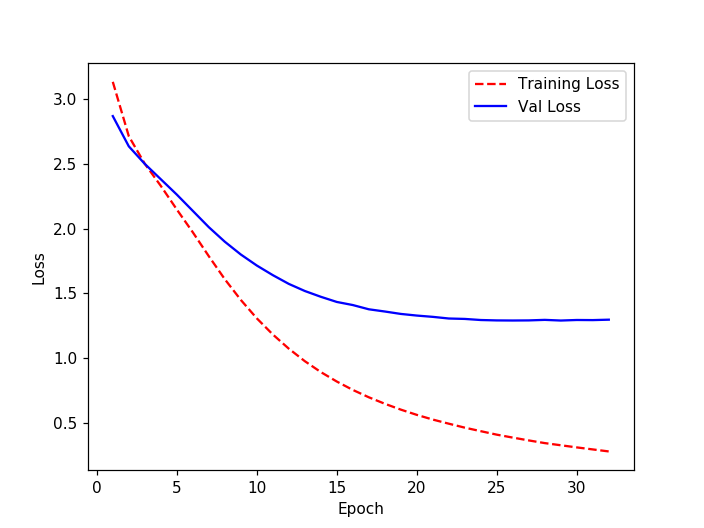

In [38]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

<IPython.core.display.Javascript object>


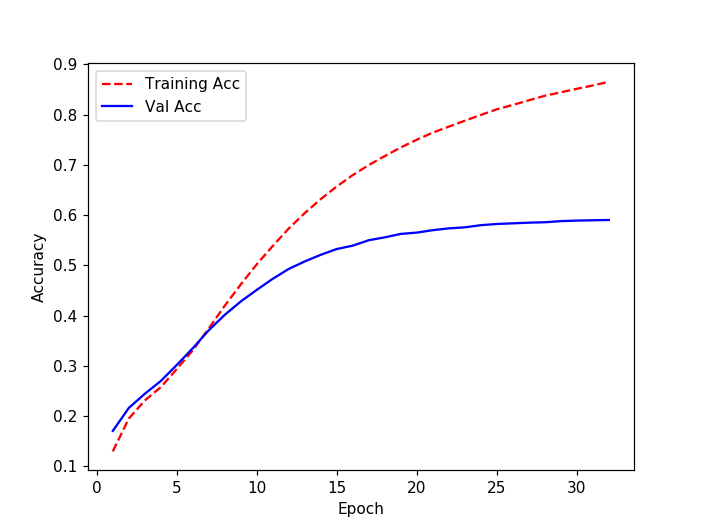

In [39]:
# Get training and test loss histories
training_acc = history.history['acc']
test_acc = history.history['val_acc']

# Create count of the number of epochs
epoch_count = range(1, len(training_acc) + 1)

# Visualize loss history
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training Acc', 'Val Acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

### Evaluate model

In [32]:
model.evaluate([val_encoder_input_data, val_decoder_input_data], val_decoder_target_data)

5000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.2849974447250365, 0.5924839]

In [33]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(units,))
decoder_state_input_c = Input(shape=(units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs2] + decoder_states2)

### Testing

In [34]:
# model = load_model('./models/sparse_best.h5')

In [35]:
# model.layers

### Make predictions

In [86]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_tk.word_index['<s>']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, f_h, f_c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = target_tk_rev[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '<e>' or len(decoded_sentence) > max_tar_len):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [f_h, f_c]

    return decoded_sentence.lstrip()

In [111]:
rand = np.random.randint(0, len(encoder_input_data))
print('Input:')
print(' '.join([input_tk_rev[w] for w in encoder_input_data[rand] if w != 0]))
print('\n')

print('Target')
print(' '.join([target_tk_rev[w] for w in decoder_target_data[rand] if w != 0]))
print('\n')

print('Prediction:')
print(decode_sequence(np.array([encoder_input_data[rand]])))

Input:
nha kha gia thi moi nguoi giup it va nguoc lai .


Target
nhà khá giả thì mọi người giúp ít và ngược lại . <e>


Prediction:
nhà khá giả thì mọi người giúp ít và ngược lại .
